In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shap
import lightgbm as lgb
import h5py

from pathlib import Path
from joblib import load
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold


import wfm

shap.initjs()

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
root_path = Path().resolve().parent
input_path = root_path  / "input"
images_path = root_path / "images"
output_path = root_path / "output"
binary_path = output_path / "binary"

input_data = wfm.preprocessing.get_input_data(input_path)
input_data.head()

INFO:wfm.preprocessing:Reading /mnt/d/Users/alonsolml/Documents/git/wildfires-modeling/input/limache/Edificaciones.shp file.
INFO:wfm.preprocessing:Reading /mnt/d/Users/alonsolml/Documents/git/wildfires-modeling/input/miraflores/Edificaciones.shp file.
INFO:wfm.preprocessing:Reading /mnt/d/Users/alonsolml/Documents/git/wildfires-modeling/input/quilpué/Edificaciones.shp file.
INFO:wfm.preprocessing:Reading /mnt/d/Users/alonsolml/Documents/git/wildfires-modeling/input/rocuant/Edificaciones.shp file.
INFO:wfm.preprocessing:Reading /mnt/d/Users/alonsolml/Documents/git/wildfires-modeling/input/rodelillo/Edificaciones.shp file.


,wildfire,id,año,material,npisos,h_viv,n_daño,orientacio,elevación,pendiente,...,fact_agua,n_conjman,d_conj_man,n_conj10m,d_conj_10m,n_conj20m,d_conj_20m,cord_x,cord_y,geometry
0,Limache,0,1978.0,Sólido,1.0,2.5,Ninguno,E,67.4828,11.326300,...,No,6.0,10.0000,13.0,10.0000,4.0,20.0000,291295.0,6347530.0,"POLYGON ((291288.520 6347524.396, 291294.786 6..."
1,Limache,0,2004.0,Liviano,1.0,2.5,Ninguno,E,67.9629,10.550100,...,No,6.0,10.0000,13.0,10.0000,4.0,20.0000,291301.0,6347550.0,"POLYGON ((291298.638 6347547.595, 291299.696 6..."
2,Limache,0,2009.0,Liviano,1.0,2.5,Ninguno,E,64.9530,10.819000,...,No,6.0,10.0000,13.0,10.0000,4.0,20.0000,291300.0,6347520.0,"POLYGON ((291298.469 6347519.147, 291300.967 6..."
3,Limache,0,1978.0,Liviano,1.0,2.5,Ninguno,E,61.4631,0.953306,...,No,6.0,10.0000,12.0,10.0000,4.0,20.0000,291334.0,6347500.0,"POLYGON ((291329.666 6347502.326, 291340.503 6..."
4,Limache,0,1978.0,Sólido,1.0,2.5,Ninguno,E,61.5823,0.693135,...,No,6.0,23.5041,12.0,23.5041,4.0,37.6067,291371.0,6347510.0,"POLYGON ((291363.407 6347527.937, 291365.271 6..."


In [3]:
model_objective = "binary"
X_display, y_display, X, y = wfm.model.get_display_and_numeric_data(
    input_data,
    wfm.constants.X_COLUMNS,
    wfm.constants.TARGET_COLUMN,
    model_objective,
)

test_size=0.25
split_random_state=42
model_random_state=42

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=test_size,
    random_state=split_random_state
)

# model = load(binary_path / "model.joblib")
# with h5py.File(binary_path / "shap_values.h5", "r") as f:
#     shap_values = f["shap_values"]

In [4]:
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

In [5]:
MODEL_PARAMETERS = {
    "multiclass":{
        'objective': "multiclassova",
        'num_class':3,
        'metric': "multi_logloss",
        "is_unbalance": True,
        # "learning_rate": 0.01,
        # "max_depth":12,
        "verbose": -1,
    },
    "binary": {
        'objective': "binary",
        "metric": "binary_logloss",
        "is_unbalance": True,
        "learning_rate": 0.01,
        "num_leaves": 10,
        # "max_depth":12,
        # "mini_data_per_leaf": 1,
        # "feature_fraction": 0.7,
        # "lambda_l1": 0.1,
        # "lambda_l2": 0.1,
        # "scale_pos_weight": 10,
        "verbose": -1,
    }
}

In [6]:
model = lgb.train(MODEL_PARAMETERS["binary"], d_train, 10000, valid_sets=[d_test], verbose_eval=1000)

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[1000]	valid_0's binary_logloss: 0.194202
[2000]	valid_0's binary_logloss: 0.165432
[3000]	valid_0's binary_logloss: 0.16857
[4000]	valid_0's binary_logloss: 0.184589
[5000]	valid_0's binary_logloss: 0.20475
[6000]	valid_0's binary_logloss: 0.22857
[7000]	valid_0's binary_logloss: 0.249
[8000]	valid_0's binary_logloss: 0.271231
[9000]	valid_0's binary_logloss: 0.291204
[10000]	valid_0's binary_logloss: 0.311305


In [7]:
y_pred = model.predict(X_test)

In [8]:
from sklearn.metrics import classification_report
print(
    classification_report(
        y_test,
        y_pred.round(0),
    )
)

              precision    recall  f1-score   support

       False       0.97      0.97      0.97       659
        True       0.74      0.70      0.72        70

    accuracy                           0.95       729
   macro avg       0.86      0.84      0.85       729
weighted avg       0.95      0.95      0.95       729



In [9]:
# explainer = shap.Explainer(model)
# shap_values = explainer(X)

In [10]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [25]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_display.iloc[0,:])

In [21]:
i = 450

In [22]:
y_display[i]

'Dañada'

In [23]:
shap.force_plot(explainer.expected_value[1], shap_values[1][i,:], X_display.iloc[i,:])

In [12]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X_display.iloc[:1000,:])

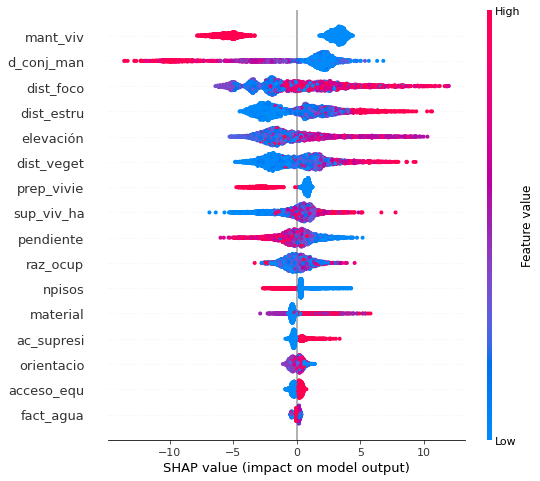

In [13]:
shap.summary_plot(shap_values[1], X)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


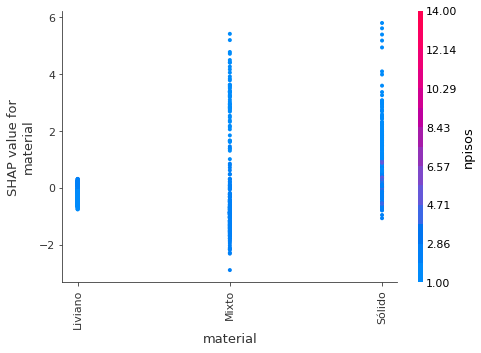

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


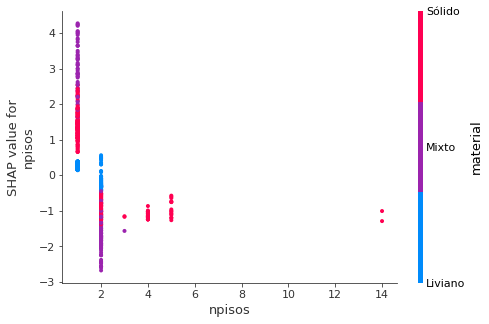

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


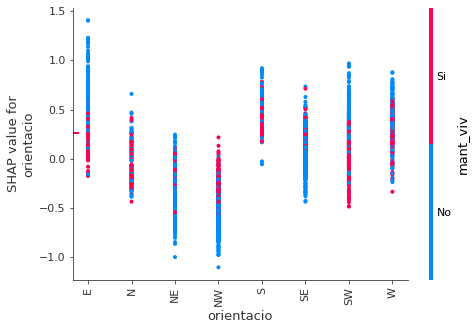

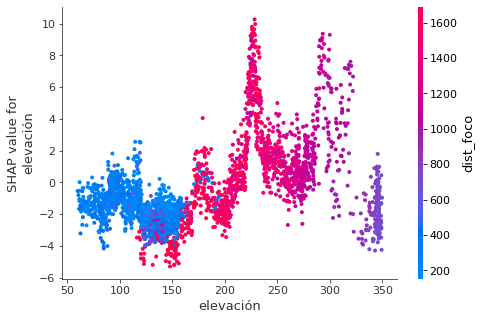

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


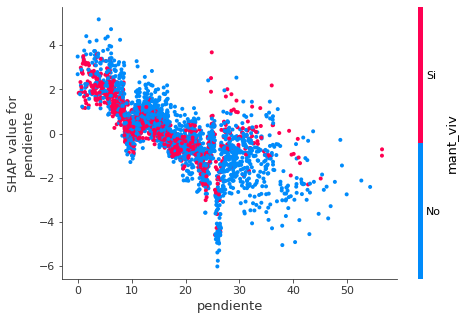

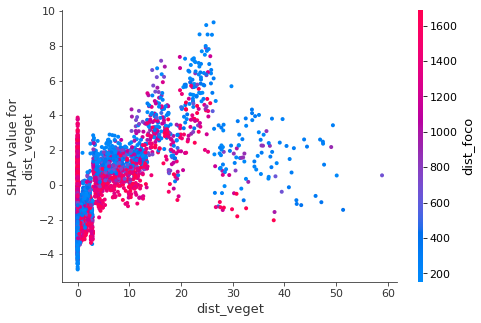

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


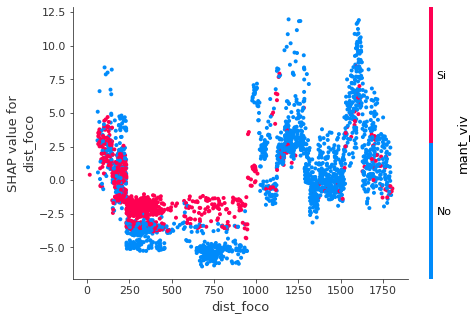

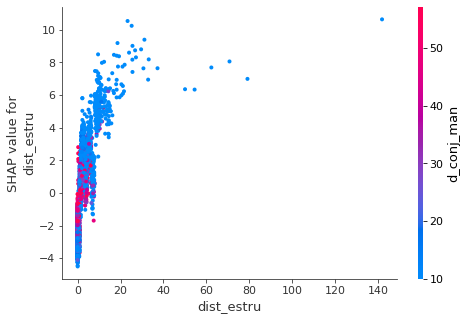

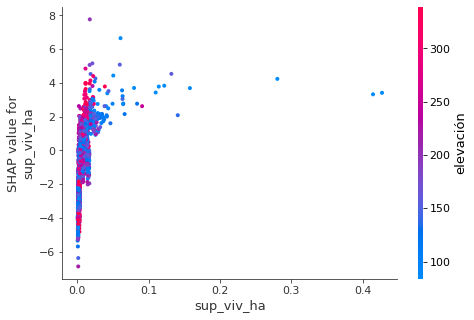

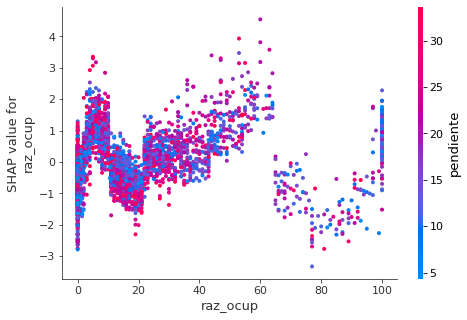

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


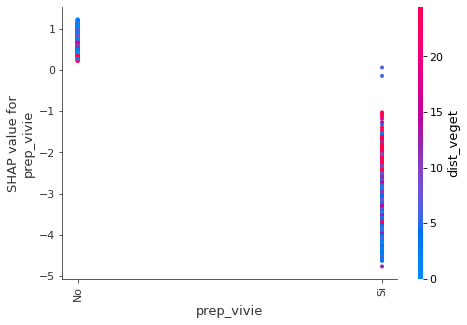

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


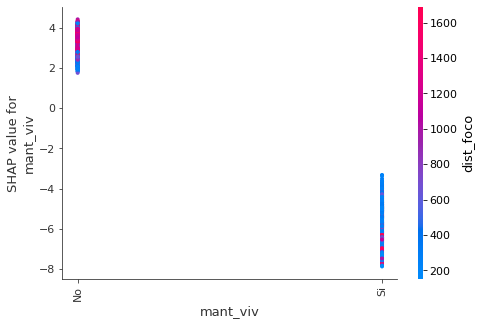

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


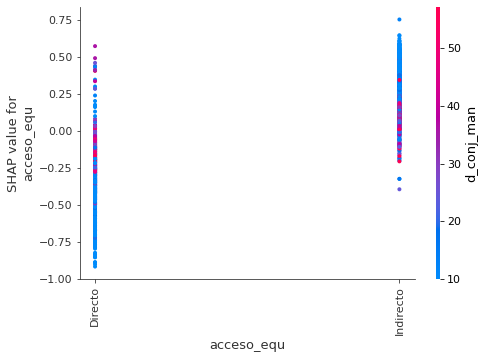

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


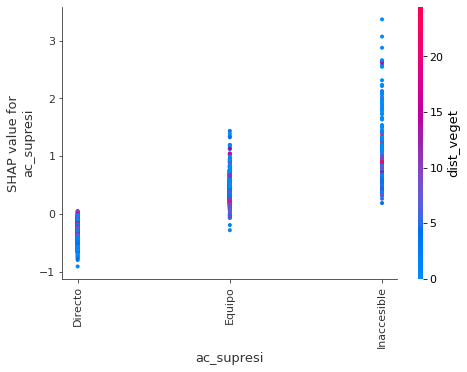

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


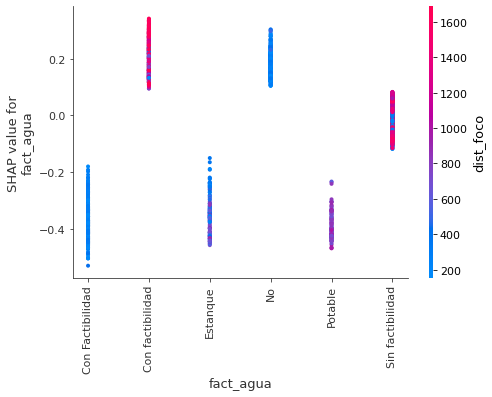

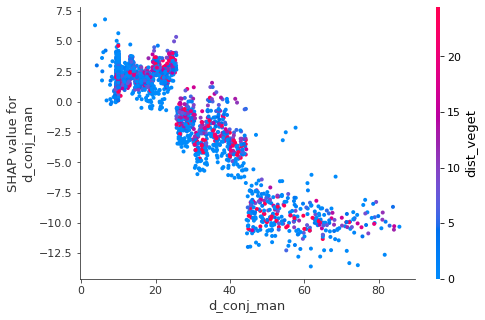

In [14]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values[1], X, display_features=X_display, interaction_index='auto')

In [15]:
shap.waterfall_plot(explainer.base_values[0], explainer.values[0], X[0])

AttributeError: 'Tree' object has no attribute 'base_values'

In [ ]:
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values)

In [ ]:
shap.summary_plot(
        shap_values,
        X,
        max_display=X.shape[1],
#         class_names=model.classes_,
#         show=False
    )

In [ ]:
type(shap_values)

In [ ]:
expainer = shap.Explainer(model) # masker required
shap_values = explainer(X)

# use the following function for waterfall
shap.plots.waterfall(
    shap_values,
#     features=X[0],
#     feature_names=X.columns
)

In [ ]:
shap.plots.force(explainer.expected_value[0], shap_values[0])

In [ ]:
col = "mant_viv"
shap.dependence_plot(
    col,
    shap_values[0],  # Danada
    X,
    display_features=X_display
)